## Figure 4

- Panel A: Coefficient Plot
- Panel B: Min/Max Image Montage (4 examples per top feature)

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


In [2]:
figure_dir <- "../figures"
output_main_figure_3 <- file.path(
    figure_dir, "main_figure_4_feature_importance.png"
)
results_dir <- file.path(
    "../../2.evaluate_models/classify_genotypes/model_evaluation_data"
)

## Generate coefficient plot

In [3]:
# Load data
feat_import_file <- file.path(results_dir, "feature_importances.parquet")

feat_import_df <- arrow::read_parquet(feat_import_file)

dim(feat_import_df)
head(feat_import_df)

[1] 852   2

feature_names,feature_importances
<chr>,<dbl>
Nuclei_AreaShape_Zernike_7_1,-0.03704024
Nuclei_RadialDistribution_ZernikePhase_RFP_4_4,-0.05366707
Cells_RadialDistribution_ZernikePhase_CY5_6_4,-0.03551811
Nuclei_RadialDistribution_ZernikeMagnitude_GFP_7_3,-0.05796016
Cytoplasm_Correlation_RWC_DAPI_RFP,-0.14077001
Cytoplasm_Texture_InfoMeas1_DAPI_3_03_256,0.58009995


In [4]:
# Split out components of feature name for visualization
feat_import_df <- feat_import_df %>%
    dplyr::arrange(desc(abs(feature_importances))) %>%
    tidyr::separate(
        feature_names,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2",
            "parameter3"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

# Convert the feature_importances to the absolute value
feat_import_df <- feat_import_df %>%
  mutate(feature_importances = abs(feature_importances))

feat_import_df$channel_cleaned <- dplyr::recode(feat_import_df$channel_cleaned,
    "DAPI" = "Nucleus",
    "GFP" = "ER",
    "RFP" = "Actin",
    "CY5" = "Mito",
    .default = "other",
    .missing = "other"
)

channels <- c(
    "Mito" = "Mito",
    "Nucleus" = "DNA",
    "ER" = "ER",
    "Actin" = "Actin",
    "other" = "other"
)

feat_import_df <- feat_import_df %>%
    dplyr::filter(channel_cleaned %in% names(channels)) %>%
    dplyr::group_by(feature_group, channel_cleaned, compartment) %>%
    dplyr::slice_max(order_by = feature_importances, n = 1)

print(dim(feat_import_df))
head(feat_import_df, 3)

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 769 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 23, 24, ...].”


[1] 59 10


feature_names,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,feature_importances,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Cells_AreaShape_Zernike_2_0,Cells,AreaShape,Zernike,2,0,NA,NA,0.5257263,other
Cytoplasm_AreaShape_FormFactor,Cytoplasm,AreaShape,FormFactor,NA,NA,NA,NA,0.6612655,other
Nuclei_AreaShape_Zernike_2_2,Nuclei,AreaShape,Zernike,2,2,NA,NA,0.4803662,other


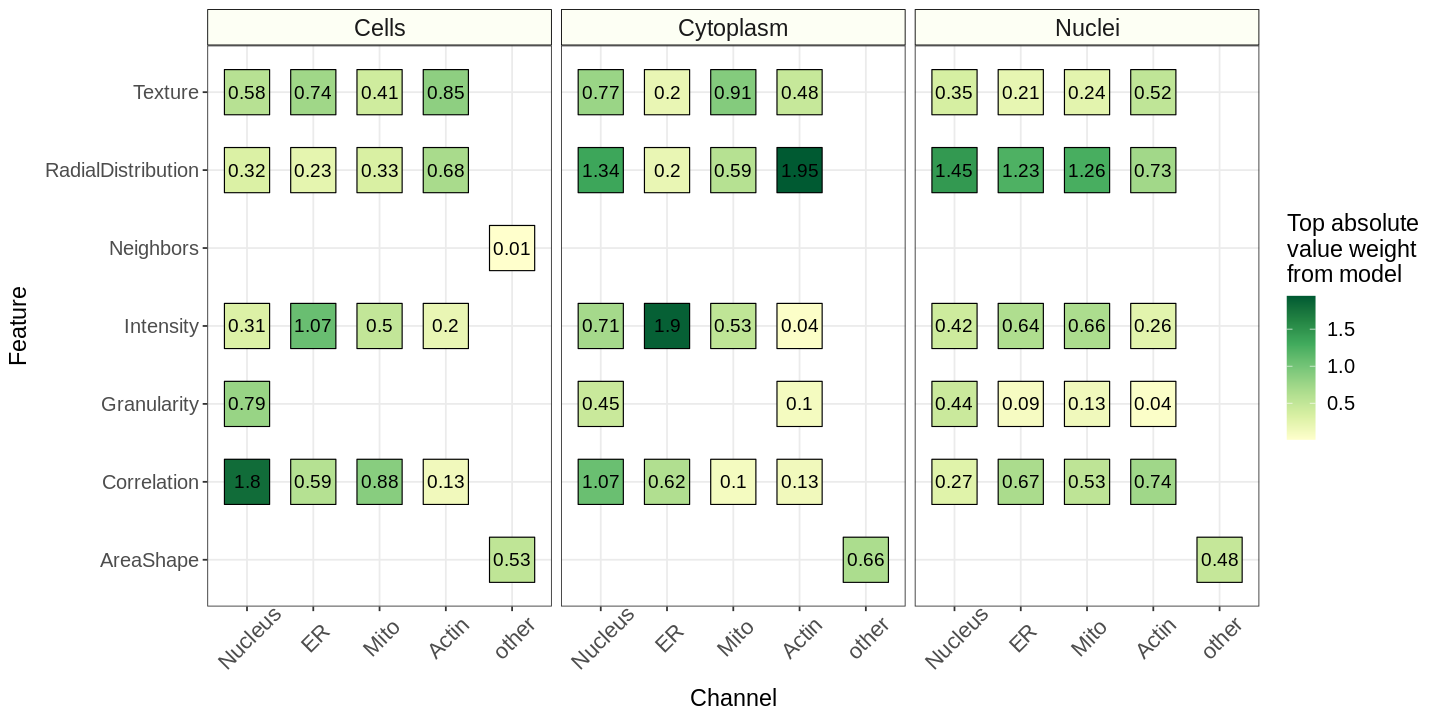

In [5]:
# Add rounded coefficient values to the data frame
feat_import_df <- feat_import_df %>%
    mutate(rounded_coeff = round(feature_importances, 2))

# Reorder the channel_cleaned factor levels
channel_order <- c("Nucleus", "ER", "Mito", "Actin", "other")
feat_import_df <- feat_import_df %>%
    mutate(channel_cleaned = factor(channel_cleaned, levels = channel_order))

width <- 12
height <- 6
options(repr.plot.width = width, repr.plot.height = height)

# Create the plot
feature_importance_gg <- (
    ggplot(feat_import_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = feature_importances), pch = 22, size = 14)
    + geom_text(aes(label = rounded_coeff), size = 4)
    + facet_wrap("~compartment", ncol = 3)
    + theme_bw()
    + scale_fill_distiller(
        name = "Top absolute\nvalue weight\nfrom model",
        palette = "YlGn",
        direction = 1
    )
    + xlab("Channel")
    + ylab("Feature")
    + theme(
        axis.text = element_text(size = 12),
        axis.text.x = element_text(angle = 45, size = 13, vjust = 0.7, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.position = "right"
    )
)

ggsave("./coefficient_plot.png", feature_importance_gg, width=width, height=height, dpi=500)

feature_importance_gg